In [ ]:

# # Student Dropout Prediction – Prototype
# Dataset: UCI "Predict Students' Dropout and Academic Success" (ID: 697)

# 1. Imports

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import joblib


# 2. Load dataset from UCI

dataset =  pd.read_csv("data.csv",sep=';') # Predict Students' Dropout and Academic Success

X = dataset.data.features
y = dataset.data.targets

print("Features shape:", X.shape)
print("Targets shape:", y.shape)
print("Target columns:", y.columns)

# For this dataset, the target column is often named something like 'Target'
# Show first few rows to confirm:
display(y.head())


# 3. Prepare features (X) and target (y)

# If there is only one target column, convert to 1D array
if y.shape[1] == 1:
    y = y.iloc[:, 0]
else:
    # If there are multiple target columns, pick the main status column
    # Adjust this line to the actual column name if needed
    y = y['Target']  # change if your column is named differently

print("Unique target values:", y.unique())


# 4. Train-test split (80/20 recommended by dataset authors)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


# 5. Identify numeric and categorical columns

numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))


# 6. Preprocessing pipeline

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)


# 7. Baseline model – Multinomial Logistic Regression

log_reg = LogisticRegression(
    multi_class="multinomial",
    max_iter=1000,
    class_weight="balanced"  # handle class imbalance
)

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", log_reg)
])

log_reg_clf.fit(X_train, y_train)

y_pred_log = log_reg_clf.predict(X_test)



print("=== Logistic Regression – Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

cm_log = confusion_matrix(y_test, y_pred_log, labels=y.unique())
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=y.unique())
disp_log.plot(xticks_rotation=45)
plt.title("Logistic Regression – Confusion Matrix")
plt.tight_layout()
plt.show()


# 8. Advanced model – Random Forest

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf)
])

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print("=== Random Forest – Test Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=y.unique())
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=y.unique())
disp_rf.plot(xticks_rotation=45)
plt.title("Random Forest – Confusion Matrix")
plt.tight_layout()
plt.show()


# 9. Cross-validation on training set (optional, for robustness)

cv_scores = cross_val_score(
    rf_clf,
    X_train,
    y_train,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

print("Random Forest 5-fold CV F1 (weighted):", cv_scores)
print("Mean F1:", cv_scores.mean(), "Std:", cv_scores.std())




#save the models
joblib.dump(log_reg_clf, "student_dropout_logreg_model.pkl")
joblib.dump(rf_clf, "student_dropout_rf_model.pkl")



# ---------------------------
# Load the trained pipeline
# ---------------------------
MODEL_PATH1= "student_dropout_logreg_model.pkl"
pipeline1 = joblib.load(MODEL_PATH1)
MODEL_PATH2= "student_dropout_rf_model.pkl"
pipeline2 = joblib.load(MODEL_PATH2)

# ---------------------------
# Example new student input
# ---------------------------
new_student = {
    'Marital Status': 1,
    'Application mode': 1,
    'Application order': 2,
    'Course': 1,
    'Daytime/evening attendance': 1,
    'Previous qualification': 1,
    'Previous qualification (grade)': 120.0,
    'Nacionality': 1,
    "Mother's qualification": 2,
    "Father's qualification": 2,
    "Mother's occupation": 4,
    "Father's occupation": 4,
    'Admission grade': 140.0,
    'Displaced': 0,
    'Educational special needs': 0,
    'Debtor': 0,
    'Tuition fees up to date': 1,
    'Gender': 1,
    'Scholarship holder': 0,
    'Age at enrollment': 19,
    'International': 0,
    'Curricular units 1st sem (credited)': 0,
    'Curricular units 1st sem (enrolled)': 6,
    'Curricular units 1st sem (evaluations)': 6,
    'Curricular units 1st sem (approved)': 5,
    'Curricular units 1st sem (grade)': 13.2,
    'Curricular units 1st sem (without evaluations)': 0,
    'Curricular units 2nd sem (credited)': 0,
    'Curricular units 2nd sem (enrolled)': 6,
    'Curricular units 2nd sem (evaluations)': 6,
    'Curricular units 2nd sem (approved)': 6,
    'Curricular units 2nd sem (grade)': 14.1,
    'Curricular units 2nd sem (without evaluations)': 0,
    'Unemployment rate': 6.5,
    'Inflation rate': 1.2,
    'GDP': 2.1
}

# ---------------------------
# Convert to DataFrame
# ---------------------------
df_new = pd.DataFrame([new_student])

# ---------------------------
# Run Prediction
# ---------------------------
prediction = pipeline1.predict(df_new)[0]
prediction2 = pipeline2.predict(df_new)[0]

print("======================================")
print(" Predicted Student Outcome:", prediction)
print("======================================")
print(" Predicted Student Outcome (RF):", prediction2)













Dataset loaded. Shape: (4424, 37)
Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approv

/opt/anaconda3/envs/tf-mac/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


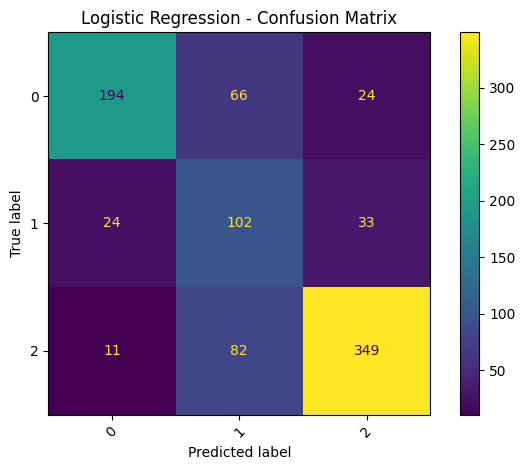


Models saved successfully!
['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# =========================================================
# 1. Load Dataset (semicolon-separated)
# =========================================================
dataset = pd.read_csv("data.csv", sep=';')

print("Dataset loaded. Shape:", dataset.shape)
print(dataset.columns)

# =========================================================
# 2. Split into Features (X) and Target (y)
# =========================================================

# The label column is named "Target"
y = dataset["Target"]
X = dataset.drop(columns=["Target"])




print("Features shape:", X.shape)
print("Targets shape:", y.shape)
print("Unique target values:", y.unique())

# =========================================================
# 3. Train/Test Split
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)




# =========================================================
# 4. Identify Numeric and Categorical Columns
# =========================================================
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# =========================================================
# 5. Preprocessing Pipelines
# =========================================================
numeric_transformer = Pipeline(steps=[
    ("scale", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# =========================================================
# 6. Logistic Regression Model
# =========================================================
log_reg = LogisticRegression(
    multi_class="multinomial",
    max_iter=1000,
    class_weight="balanced"
)

log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", log_reg)
])

log_reg_clf.fit(X_train, y_train)
y_pred_log = log_reg_clf.predict(X_test)

print("\n=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

cm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cm_log).plot(xticks_rotation=45)
plt.title("Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.show()





# =========================================================
# 9. Save Both Models
# =========================================================
joblib.dump(log_reg_clf, "student_dropout_logreg_model.pkl")


print("\nModels saved successfully!")

# =========================================================
# 10. Load Models and Predict New Student
# =========================================================
pipeline1 = joblib.load("student_dropout_logreg_model.pkl")


new_student = {
    'Marital status': 1,
    'Application mode': 1,
    'Application order': 2,
    'Course': 1,
    'Daytime/evening attendance\t': 1,
    'Previous qualification': 1,
    'Previous qualification (grade)': 120.0,
    'Nacionality': 1,
    "Mother's qualification": 2,
    "Father's qualification": 2,
    "Mother's occupation": 4,
    "Father's occupation": 4,
    'Admission grade': 140.0,
    'Displaced': 0,
    'Educational special needs': 0,
    'Debtor': 0,
    'Tuition fees up to date': 1,
    'Gender': 1,
    'Scholarship holder': 0,
    'Age at enrollment': 19,
    'International': 0,
    'Curricular units 1st sem (credited)': 0,
    'Curricular units 1st sem (enrolled)': 6,
    'Curricular units 1st sem (evaluations)': 6,
    'Curricular units 1st sem (approved)': 5,
    'Curricular units 1st sem (grade)': 13.2,
    'Curricular units 1st sem (without evaluations)': 0,
    'Curricular units 2nd sem (credited)': 0,
    'Curricular units 2nd sem (enrolled)': 6,
    'Curricular units 2nd sem (evaluations)': 6,
    'Curricular units 2nd sem (approved)': 6,
    'Curricular units 2nd sem (grade)': 14.1,
    'Curricular units 2nd sem (without evaluations)': 0,
    'Unemployment rate': 6.5,
    'Inflation rate': 1.2,
    'GDP': 2.1
}

df_new = pd.DataFrame([new_student])

print(dataset.columns.tolist())

print(X_train.columns.tolist())

pred1 = pipeline1.predict(df_new)[0]


print("\nPredicted (Logistic Regression):", pred1)





Solving the classification problem using deep learning tecnique TensorFlow


Dataset loaded. Shape: (4424, 37)
Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (appro

2025-12-06 07:53:07.184049: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-06 07:53:07.184242: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-06 07:53:07.184255: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-06 07:53:07.185002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-06 07:53:07.185288: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                370       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 513 (2.00 KB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/50


2025-12-06 07:53:07.790265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


354/354 [==============================] - ETA: 0s - loss: 0.9358 - accuracy: 0.5869

2025-12-06 07:53:12.794425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


354/354 [==============================] - 6s 16ms/step - loss: 0.9358 - accuracy: 0.5869 - val_loss: 0.7433 - val_accuracy: 0.6949
Epoch 2/50
354/354 [==============================] - 5s 14ms/step - loss: 0.7163 - accuracy: 0.7112 - val_loss: 0.6800 - val_accuracy: 0.7322
Epoch 3/50
354/354 [==============================] - 5s 14ms/step - loss: 0.6598 - accuracy: 0.7299 - val_loss: 0.6519 - val_accuracy: 0.7390
Epoch 4/50
354/354 [==============================] - 5s 13ms/step - loss: 0.6270 - accuracy: 0.7443 - val_loss: 0.6388 - val_accuracy: 0.7480
Epoch 5/50
354/354 [==============================] - 5s 14ms/step - loss: 0.6084 - accuracy: 0.7539 - val_loss: 0.6235 - val_accuracy: 0.7537
Epoch 6/50
354/354 [==============================] - 5s 13ms/step - loss: 0.5964 - accuracy: 0.7564 - val_loss: 0.6238 - val_accuracy: 0.7514
Epoch 7/50
354/354 [==============================] - 4s 12ms/step - loss: 0.5892 - accuracy: 0.7621 - val_loss: 0.6116 - val_accuracy: 0.7650
Epoch 8/50

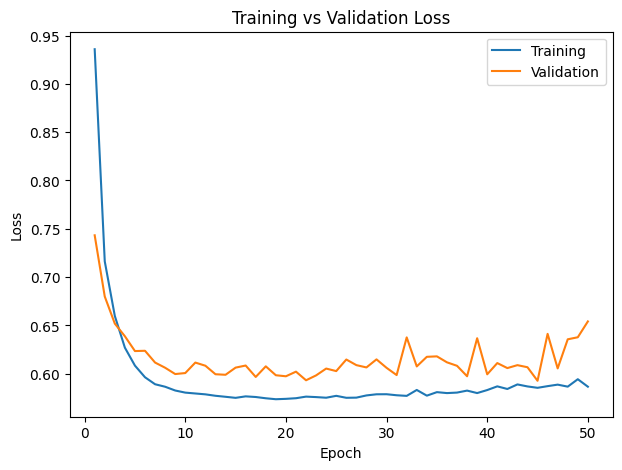


----------------------------------------
Layer: dense
Weights:
 [[-8.88230503e-02 -8.41336489e-01  6.91803217e-01 -5.75995706e-02
  -7.00743556e-01 -2.88197994e-02  2.99195737e-01 -2.43704185e-01
   3.59468371e-01 -1.12278461e+00]
 [ 5.04861653e-01  1.42337763e+00 -1.55177605e+00 -1.45139903e-01
   8.75154376e-01  1.35692191e+00 -8.54742229e-01  2.15915307e-01
   3.74473244e-01  8.82046938e-01]
 [-1.19120526e+00 -3.64833325e-01  2.35919077e-02 -8.50621045e-01
  -4.18995768e-01 -9.21014965e-01  7.04167262e-02 -8.67387801e-02
   1.79761603e-01  4.67604190e-01]
 [ 8.92987009e-03  3.91726196e-01 -7.42224276e-01  2.81559736e-01
  -3.24752837e-01 -4.30350453e-01  4.13196772e-01 -1.19345620e-01
  -9.00969923e-01  2.85437256e-01]
 [-8.20351958e-01 -2.34732389e-01 -4.22044277e-01 -1.10253859e+00
  -5.17514288e-01  6.33582473e-01  3.74095052e-01 -1.15254116e+00
   3.62731725e-01 -1.80786952e-01]
 [ 3.44043523e-01  1.06538105e+00 -1.32258821e+00 -1.47252819e-02
   5.84868729e-01  5.67616224e-01 

2025-12-06 07:57:02.123439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


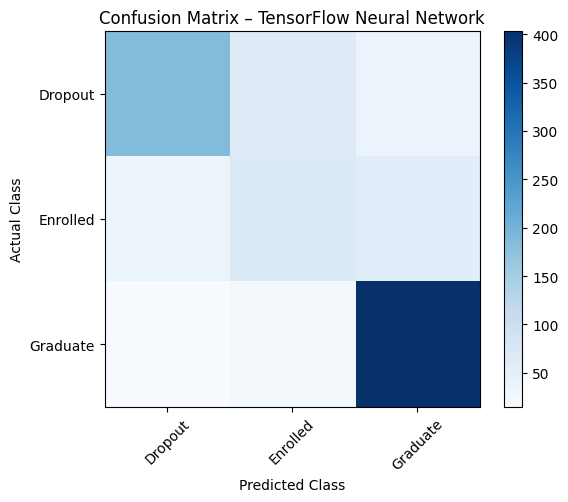

/opt/anaconda3/envs/tf-mac/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model saved as: student_dropout_tf_model.h5


In [3]:


# ============================================================
# 0. IMPORTS & SETUP
# ============================================================

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras import optimizers, utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# ============================================================
# 1. LOAD DATA
# ============================================================

df = pd.read_csv("data.csv",sep=';')

print("\nDataset loaded. Shape:", df.shape)
print(df.columns)


# Separate features and target
X = df.drop(columns=["Target"])
y = df["Target"]

# Identify categorical and numeric columns
numeric_cols = [col for col in X.columns if X[col].dtype != "object"]
categorical_cols = [col for col in X.columns if X[col].dtype == "object"]

print("\nNumeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))

# ============================================================
# 2. TRAIN/TEST SPLIT
# ============================================================

X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


print("\nTrain shape:", X_train.shape)
print("Test shape :", X_test.shape)

tf.random.set_seed(0)
# ============================================================
# 3. PREPROCESSING WITH COLUMNTRANSFORMER
# ============================================================

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# Fit/transform
X_train_tf = preprocess.fit_transform(X_train)
X_test_tf  = preprocess.transform(X_test)

print("\nTransformed train shape:", X_train_tf.shape)
print("Transformed test shape :", X_test_tf.shape)

# ============================================================
# 4. LABEL ENCODING (for TensorFlow)
# ============================================================

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train_raw)
y_test_enc  = label_encoder.transform(y_test_raw)

# One-hot encode labels
y_train_cat = utils.to_categorical(y_train_enc)
y_test_cat  = utils.to_categorical(y_test_enc)

num_classes = y_train_cat.shape[1]
num_features = X_train_tf.shape[1]

print("\nClasses detected:", label_encoder.classes_)
print("Number of features:", num_features)
print("Number of classes:", num_classes)

# Convert float32 (required for TensorFlow)
X_train_tf = X_train_tf.astype("float32")
X_test_tf = X_test_tf.astype("float32")

print("\nData ready...")

# ============================================================
# 5. BUILD TENSORFLOW MODEL (same structure as your wine example)
# ============================================================

hl = 10  # hidden units

model = Sequential()
model.add(Dense(hl, input_dim=num_features, activation='relu'))
model.add(Dense(hl, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

print("\nModel Summary:")
print(model.summary())

# ============================================================
# 6. COMPILE MODEL
# ============================================================

learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# ============================================================
# 7. TRAINING
# ============================================================

num_epochs = 50
history = model.fit(
    X_train_tf, y_train_cat,
    epochs=num_epochs,
    batch_size=10,
    validation_data=(X_test_tf, y_test_cat)
)

# ============================================================
# 8. PLOT TRAINING LOSS & VALIDATION LOSS
# ============================================================

epoch_nums = range(1, num_epochs + 1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]

plt.figure(figsize=(7,5))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(["Training", "Validation"])
plt.show()

# ============================================================
# 9. PRINT WEIGHTS & BIASES FOR EACH LAYER
# ============================================================

for layer in model.layers:
    weights, biases = layer.get_weights()
    print("\n----------------------------------------")
    print("Layer:", layer.name)
    print("Weights:\n", weights)
    print("Biases:\n", biases)

# ============================================================
# 10. CONFUSION MATRIX
# ============================================================

class_probs = model.predict(X_test_tf)
predictions = np.argmax(class_probs, axis=1)
true_labels = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix – TensorFlow Neural Network")
plt.tight_layout()
plt.show()

# ============================================================
# 11. SAVE MODEL
# ============================================================

model_filename = "student_dropout_tf_model.h5"
model.save(model_filename)
print("\nModel saved as:", model_filename)
